In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [3]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [4]:
ford_aliases = {
    'TOYOTA MOTOR CO., LTD.',
    'TOYOTA MOTOR NORTH AMERICA, INC.',
    'Toyota Motor Engineering & Manufacturing'
}

In [5]:
ford_df = df.loc[df['Vehicle Manufacturer'].isin(ford_aliases)]

In [6]:
ford_df_over_500k = ford_df.loc[df['Estimated Units'] > 500000.0]

In [7]:
len(ford_df_over_500k)

527

In [8]:
ford_df_filtered = ford_df_over_500k.dropna(subset=['Recall Notification Date'])

In [9]:
ford_df_filtered_with_date = ford_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [10]:
type(ford_df_filtered['Estimated Units'])

pandas.core.series.Series

In [11]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [12]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': ford_df_filtered_with_date,
        'Estimated Units': ford_df_filtered['Estimated Units']
})

In [13]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [14]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [15]:
ford_stock_data_types = {
    'Date': str,
    'Price': float
}
ford_stock = pd.read_csv('zstock_data_clean/toyota_stock.txt', sep='\t', parse_dates=['Date'])

In [16]:
ford_stock_after_1995 = ford_stock.loc[ford_stock['Date'] > date_split_value]

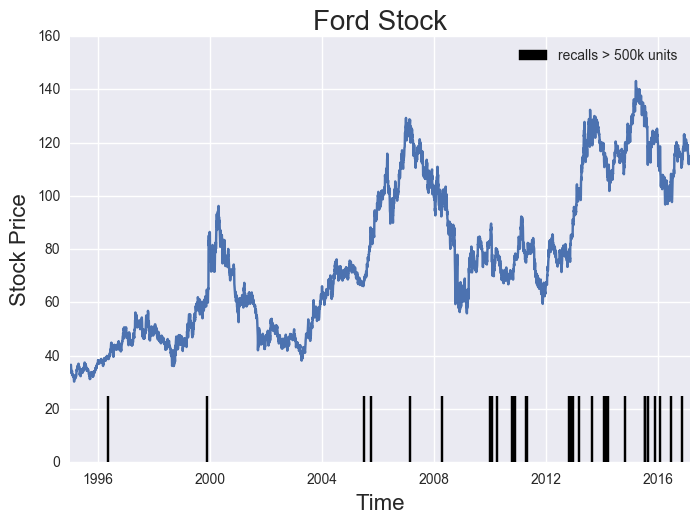

In [17]:
plt.plot(list(ford_stock_after_1995['Date']), list(ford_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[0 for x in range(0, len(my_dates_list))], ymax=[25 for x in range(0, len(my_dates_list))])
plt.title('Ford Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 500k units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [18]:
ford_stock_after_1995_reset_indices = ford_stock_after_1995.reset_index()
ford_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [19]:
# now we will conduct the event study
dates_arr = np.array(ford_stock_after_1995_reset_indices['Date'])
prices_arr = np.array(ford_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [20]:
np.argwhere(dates_arr == recalls_dates_arr[0])[0][0]

1240

In [21]:
indices_recalls_in_stocks_arrays = []
for recall_date in recalls_dates_arr:
    idx = np.argwhere(dates_arr == recall_date)
    while(len(idx) != 1):
        recall_date -= np.timedelta64(1,'D')
        idx = np.argwhere(dates_arr == recall_date)
    assert len(idx) == 1
    indices_recalls_in_stocks_arrays.append(idx[0][0])
indices_recalls_in_stocks_arrays = np.array(indices_recalls_in_stocks_arrays)
#indices_recalls_in_stocks_arrays

In [22]:
# must get stock prices for 10 days previous, take diff of today - (today - 10 days), then do paired t test to see 
# if diff is different from 0
days_from_recall = 10
indices_of_recalls_minus_ten_days = indices_recalls_in_stocks_arrays - days_from_recall
indices_of_recalls_plus_ten_days = indices_recalls_in_stocks_arrays + days_from_recall

In [23]:
assert len(indices_of_recalls_minus_ten_days) == len(indices_recalls_in_stocks_arrays)
stock_price_differences = [] # price on event - price before event
for i in range(0, len(indices_recalls_in_stocks_arrays)):
    before_price = prices_arr[indices_of_recalls_minus_ten_days[i]]
    after_price = prices_arr[indices_of_recalls_plus_ten_days[i]]
    on_event_price = prices_arr[indices_recalls_in_stocks_arrays[i]]
    #diff = on_event_price - before_price
    diff = after_price - on_event_price
    stock_price_differences.append(diff)
stock_price_differences = np.array(stock_price_differences)

In [24]:
from scipy import stats

In [25]:
the_t_statistic, the_p_value = stats.ttest_1samp(a=stock_price_differences, popmean=0)
print('t stat:', "{:.3f}".format(the_t_statistic), 'p value:', "{:.3f}".format(the_p_value))

t stat: 0.914 p value: 0.368


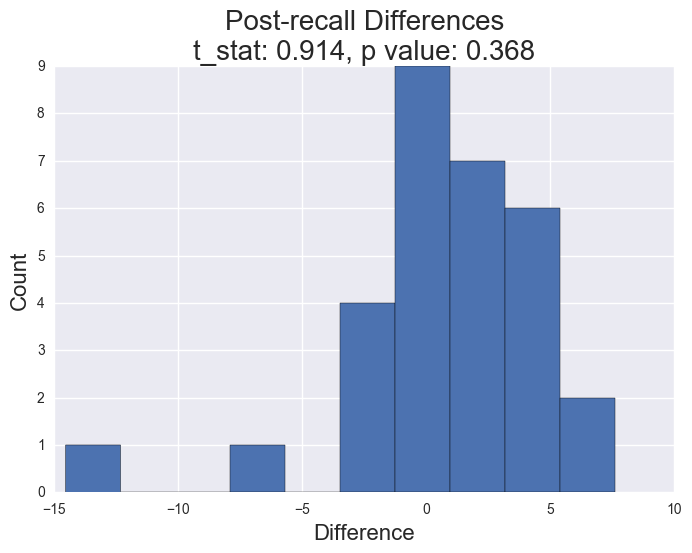

In [26]:
plt.hist(stock_price_differences)
#plt.title('Pre-recall Differences\nt_stat: {:.3f}, p value: {:.3f}'.format(the_t_statistic, the_p_value), fontsize=20)
plt.title('Post-recall Differences\nt_stat: {:.3f}, p value: {:.3f}'.format(the_t_statistic, the_p_value), fontsize=20)
plt.xlabel('Difference', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()